In [8]:
import gym
gym.logger.set_level(40)
import envs
import autograd.numpy as np
from autograd import grad, jacobian
import matplotlib.pyplot as plt
from koopman import Koopman
from controller import MPC

import random

In [9]:
env_name = "CartPoleContinuous-v0"
env = gym.make(env_name)
train_epi = 50
max_step = 500

In [10]:
def basis(state, action):
    action = action[0]
    extra_basis = np.array([np.sin(state[2]), action*np.cos(state[2])])
    action_basis = np.array([action])
    psi = np.hstack((state, extra_basis, action_basis))
    return psi

print(basis(np.zeros(4), [0]))

[0. 0. 0. 0. 0. 0. 0.]


In [11]:
num_state = env.observation_space.shape[0]
num_basis = num_state + 3
km = Koopman(basis, num_basis, num_state)

In [12]:
for i in range(train_epi):
    state = env.reset(np.array([0.0,0.0,0.0,0.0]))
    step = 0
    
    while step < max_step:
        action = env.action_space.sample()
        new_state, _, _, _ = env.step(action)

        km.collect_data(state, new_state, action)

        state = new_state
        step += 1

[[ 1.    0.02  0.   -0.    0.    0.   -0.  ]
 [-0.    1.   -0.    0.   -0.    0.    2.  ]
 [-0.    0.    1.    0.02 -0.   -0.   -0.  ]
 [-0.    0.   -0.    1.    0.18 -1.82 -0.  ]
 [ 0.   -0.    0.   -0.    0.98 -0.    0.  ]
 [ 0.    0.   -0.    0.    0.    0.98  0.  ]
 [ 0.   -0.    0.   -0.    0.    0.    1.  ]]


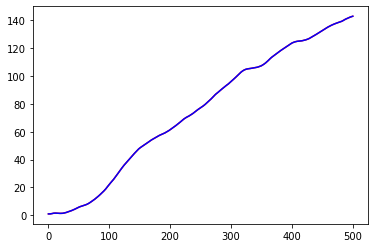

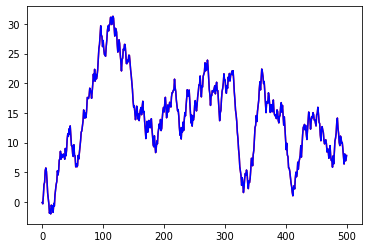

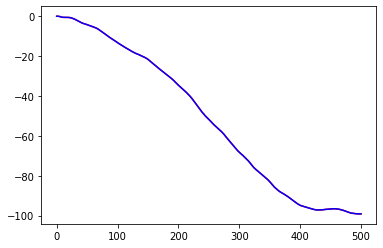

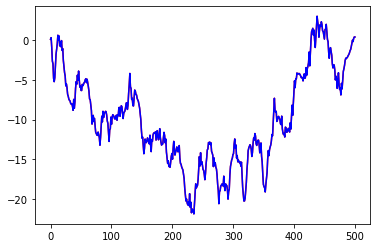

In [13]:
state = env.reset(np.array([1.0,0.0,0.0,0.0]))
predict_state = state.copy()
step = 0
predict_arr = []
actual_arr = []
K = km.get_full_K()
print(np.round(K,2))

while step < max_step:
    action = env.action_space.sample()

    #propagate actual state
    new_state, _, _, _ = env.step(action)
    actual_arr.append(new_state)

    #propagate predicted state
    K_h_T = km.get_K_h_T()
    new_predict_state = (K_h_T @ basis(predict_state, action).reshape(-1,1)).flatten()
    predict_arr.append(new_predict_state)

    #update
    state = new_state
    predict_state = new_predict_state
    step += 1
    
    
actual_arr = np.array(actual_arr)
predict_arr = np.array(predict_arr)

for s in range(4):
    plt.plot(np.linspace(0,max_step, max_step), actual_arr[:,s], color='red')
    plt.plot(np.linspace(0,max_step, max_step), predict_arr[:,s], color='blue')

    plt.show()

end


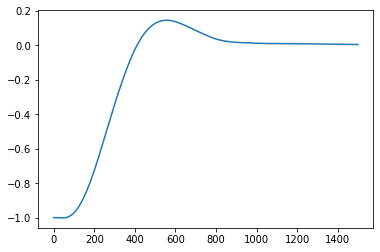

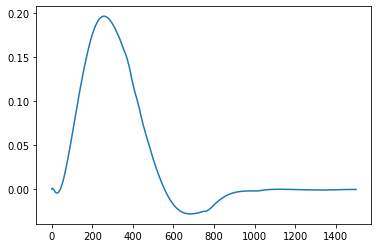

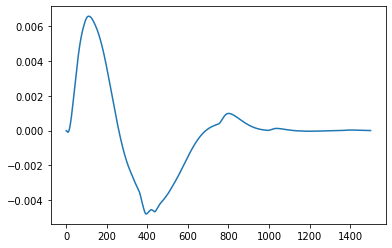

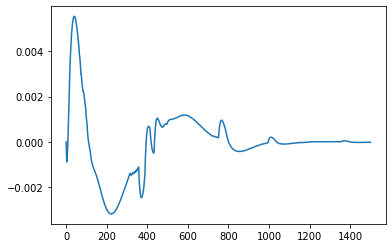

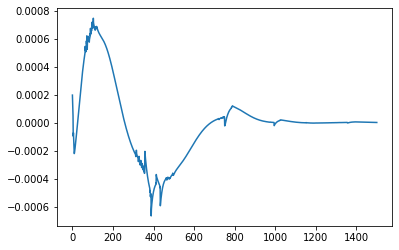

In [14]:
controller = MPC(50, km.get_K_h_T(), basis, env.dt)
state = env.reset(np.array([-1.0,0.0,0.0,0.0]))
action = np.array([0.0])
max_step = 1500

step = 0
traj_arr = []
action_arr = []

while step < max_step:

    traj_arr.append(state)
    action = controller(state, 0.001, 5, 1.0)#controller(state)#controller(state, 1.0)
    action_arr.append(action)
    new_state, _, _, _ = env.step(action)
    

    state = new_state
    step += 1
    
print('end')

traj_arr = np.array(traj_arr)
action_arr = np.array(action_arr)

t_step = np.linspace(0,max_step,max_step)
for s in range(4):
    plt.plot(t_step, traj_arr[:,s])
    plt.show()

plt.plot(t_step, action_arr)
plt.show()